In [1]:
from torchsummary import summary
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('/content/', transform = img_transform, train = True, download = True)
val_ds = MNIST('/content/', transform = img_transform, train = False, download = True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)

In [2]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride = 1, padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride = 2, padding=0),

            nn.Conv2d(32, 64, 3, stride = 1, padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride = 2, padding=0)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride = 2, padding=1, output_padding=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 1, 3, stride = 1, padding = 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoEncoder().to(device)

summary(model, torch.zeros(2, 1, 28, 28).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 7, 7]            --
|    └─Conv2d: 2-1                       [-1, 32, 28, 28]          320
|    └─ReLU: 2-2                         [-1, 32, 28, 28]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 64, 14, 14]          18,496
|    └─ReLU: 2-5                         [-1, 64, 14, 14]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 7, 7]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 14, 14]          18,464
|    └─ReLU: 2-8                         [-1, 32, 14, 14]          --
|    └─ConvTranspose2d: 2-9              [-1, 16, 28, 28]          4,624
|    └─ReLU: 2-10                        [-1, 16, 28, 28]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           145
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 7, 7]            --
|    └─Conv2d: 2-1                       [-1, 32, 28, 28]          320
|    └─ReLU: 2-2                         [-1, 32, 28, 28]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 64, 14, 14]          18,496
|    └─ReLU: 2-5                         [-1, 64, 14, 14]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 7, 7]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 14, 14]          18,464
|    └─ReLU: 2-8                         [-1, 32, 14, 14]          --
|    └─ConvTranspose2d: 2-9              [-1, 16, 28, 28]          4,624
|    └─ReLU: 2-10                        [-1, 16, 28, 28]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           145
| 

In [3]:
def train_batch(input, model, crit, opt):
    model.train()
    input = input.to(device)
    opt.zero_grad()
    output = model(input)
    loss = crit(output, input)
    loss.backward()
    opt.step()
    return loss

In [4]:
@torch.no_grad()
def validate_batch(input, model, crit):
    model.eval()
    output = model(input)
    loss = crit(output, input)
    return loss

In [5]:
model = ConvAutoEncoder().to(device)
crit = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)

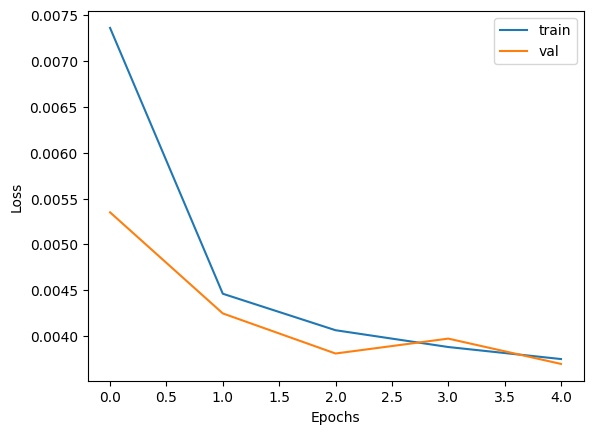

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = 5

# novo método pra guardar os valores pois o Report nao funciona
train_losses = []
val_losses = []

# esse loop roda o modelo e plota os gráficos
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0

    # treinamento
    for ix, (data, _) in enumerate(trn_ds):
        loss = train_batch(data, model, crit, opt)
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(trn_ds)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0

    # validação
    with torch.no_grad(): # nao precisa do gradiente
        for ix, (data, _) in enumerate(val_ds):
            data = data.to(device)  # Envia os dados para o dispositivo correto
            output = model(data)  # Passa os dados pelo modelo
            loss = crit(output, data)  # Calcula a perda
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_ds)
    val_losses.append(avg_val_loss)

plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()